# 1. 흐름도

## 1.1 전체 구조

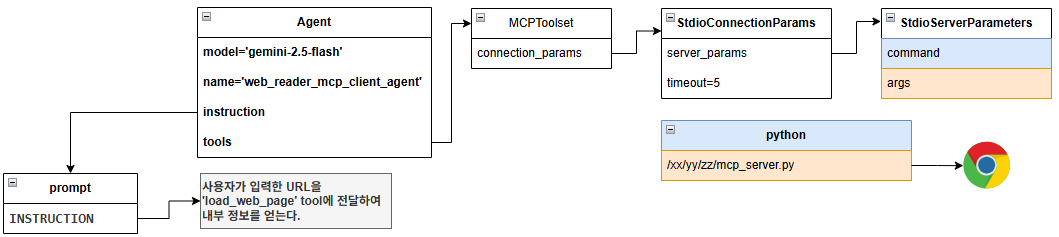

## 1.2 MCP Server

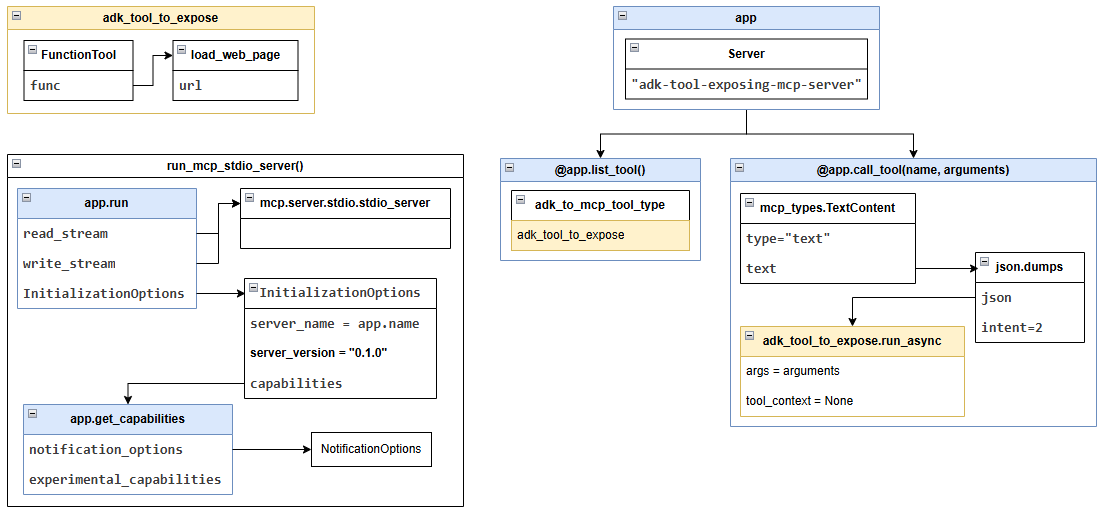

# 2. 실행

## 2.1 프로젝트 생성

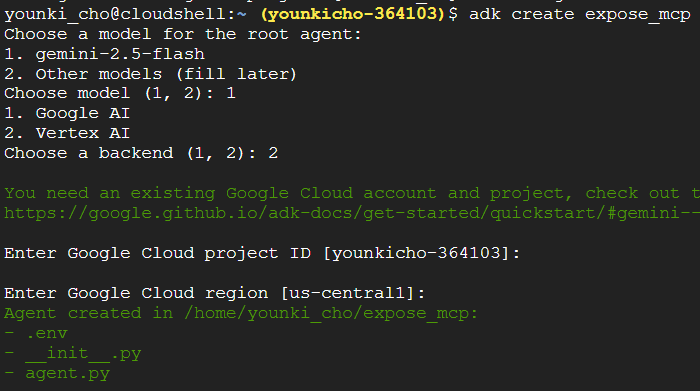

## 2.2 실행 결과 확인

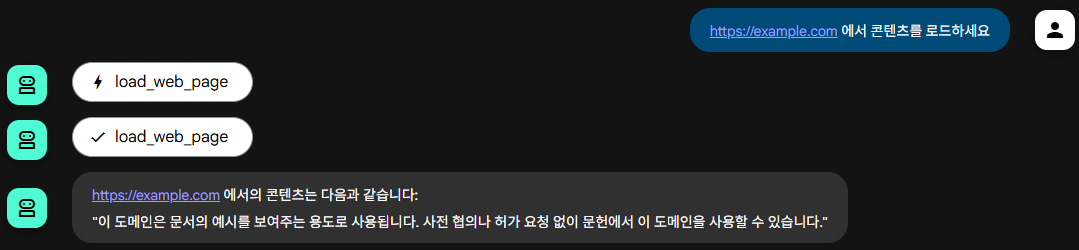

# 3. code

## 3.1 agent.py

In [ ]:
# agent.py
import os
from google.adk.agents import LlmAgent
from google.adk.tools.mcp_tool.mcp_toolset import MCPToolset
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters

from . import prompt


PATH_TO_YOUR_MCP_SERVER_SCRIPT = "/home/younki_cho/ADK/expose_mcp/mcp_server.py"

server_params = StdioServerParameters(
    command='python3',
    args=[PATH_TO_YOUR_MCP_SERVER_SCRIPT],
)
connection_params=StdioConnectionParams(
    server_params=server_params,
    timeout=30,
)
load_web_page_mcp_toolset = MCPToolset(connection_params=connection_params)

root_agent = LlmAgent(
    model='gemini-2.0-flash',
    name='web_reader_mcp_client_agent',
    instruction=prompt.INSTRUCTION,
    tools=[load_web_page_mcp_toolset],
)

## 3.2 prompt.py

In [ ]:
# prompt.py
INSTRUCTION="""
  사용자가 입력한 URL을 'load_web_page' tool에
  전달하여 웹페이지의 text 정보를 얻는다.
"""

## 3.3 mcp_server.py

In [ ]:
# mcp_server.py
import asyncio
import json

from google.adk.tools.function_tool import FunctionTool
from google.adk.tools.load_web_page import load_web_page
from google.adk.tools.mcp_tool.conversion_utils import adk_to_mcp_tool_type

from mcp import types as mcp_types
from mcp.server.lowlevel import Server, NotificationOptions
from mcp.server.models import InitializationOptions
import mcp.server.stdio


adk_tool_to_expose = FunctionTool(load_web_page)
app = Server("adk-tool-exposing-mcp-server")

@app.list_tools()
async def list_mcp_tools() -> list[mcp_types.Tool]:
    mcp_tool_schema = adk_to_mcp_tool_type(adk_tool_to_expose)
    return [mcp_tool_schema]

@app.call_tool()
async def call_mcp_tool(
    name: str, arguments: dict
) -> list[mcp_types.Content]:
    if name == adk_tool_to_expose.name:
        try:
            adk_tool_response = await adk_tool_to_expose.run_async(
                args=arguments,
                tool_context=None,
            )
            response_text = json.dumps(adk_tool_response, indent=2)
            return [mcp_types.TextContent(type="text", text=response_text)]
        except Exception as e:
            error_text = json.dumps({"error": f"Failed to execute tool '{name}': {str(e)}"})
            return [mcp_types.TextContent(type="text", text=error_text)]
    else:
        error_text = json.dumps({"error": f"Tool '{name}' not implemented by this server."})
        return [mcp_types.TextContent(type="text", text=error_text)]


async def run_mcp_stdio_server():
    async with mcp.server.stdio.stdio_server() as (read_stream, write_stream):
        await app.run(
            read_stream,
            write_stream,
            InitializationOptions(
                server_name=app.name,
                server_version="0.1.0",
                capabilities=app.get_capabilities(
                    notification_options=NotificationOptions(),
                    experimental_capabilities={},
                ),
            ),
        )


if __name__ == "__main__":
    try:
        asyncio.run(run_mcp_stdio_server())
    except KeyboardInterrupt:
        print("\nMCP Server (stdio) stopped by user.")
    except Exception as e:
        print(f"MCP Server (stdio) encountered an error: {e}")
    finally:
        print("MCP Server (stdio) process exiting.")


# 4. 참조

- https://google.github.io/adk-docs/tools/mcp-tools/